# preprocessing

In [336]:
!rm -rf TabularDS  # Remove the existing directory
!git clone https://github.com/ItamarBerger/TabularDS


Cloning into 'TabularDS'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 577 (delta 76), reused 65 (delta 26), pack-reused 387 (from 2)
Receiving objects: 100% (577/577), 42.61 MiB | 11.23 MiB/s, done.
Resolving deltas: 100% (248/248), done.
Updating files: 100% (28/28), done.


In [337]:
import sys
import os
import sys


os.listdir('/content/TabularDS/final_project')
sys.path.append('/content/TabularDS/final_project/code')



from utils.rules_mining import *
from utils.clustering import *

# 1. MovieLens 20M dataset

In [338]:
import pandas as pd
transactions = pd.read_csv('/content/TabularDS/final_project/data/movies_with_clusters.csv')
min_support = 0.18
original_min_support = min_support

# take a smaller sample of given dataset, reducing time & space complexity
transactions = transactions[0:20000]

## I. Applying Classic Apriori for rule associasion mining

In [339]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Baseline apriori results

In [340]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 3176
                          antecedents                         consequents  \
0  (Silence of the Lambs, The (1991))               (Pulp Fiction (1994))   
1               (Pulp Fiction (1994))  (Silence of the Lambs, The (1991))   
2               (Forrest Gump (1994))  (Silence of the Lambs, The (1991))   

   antecedent support  consequent support  support  confidence      lift  \
0             0.46705             0.50005  0.35420    0.758377  1.516602   
1             0.50005             0.46705  0.35420    0.708329  1.516602   
2             0.49420             0.46705  0.33175    0.671287  1.437291   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.120652    2.069133       0.639143  0.577908   0.516706   
1               1.0  0.120652    1.827231       0.681331  0.577908   0.452724   
2               1.0  0.100934    1.621323       0.601516  0.527006   0.383220   

   kulczynski  
0    0.733353  
1   

In [341]:
print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.2009, Confidence average: 0.6255, Lift average: 1.8707


## Visualize top rules
### (sorted by lift)

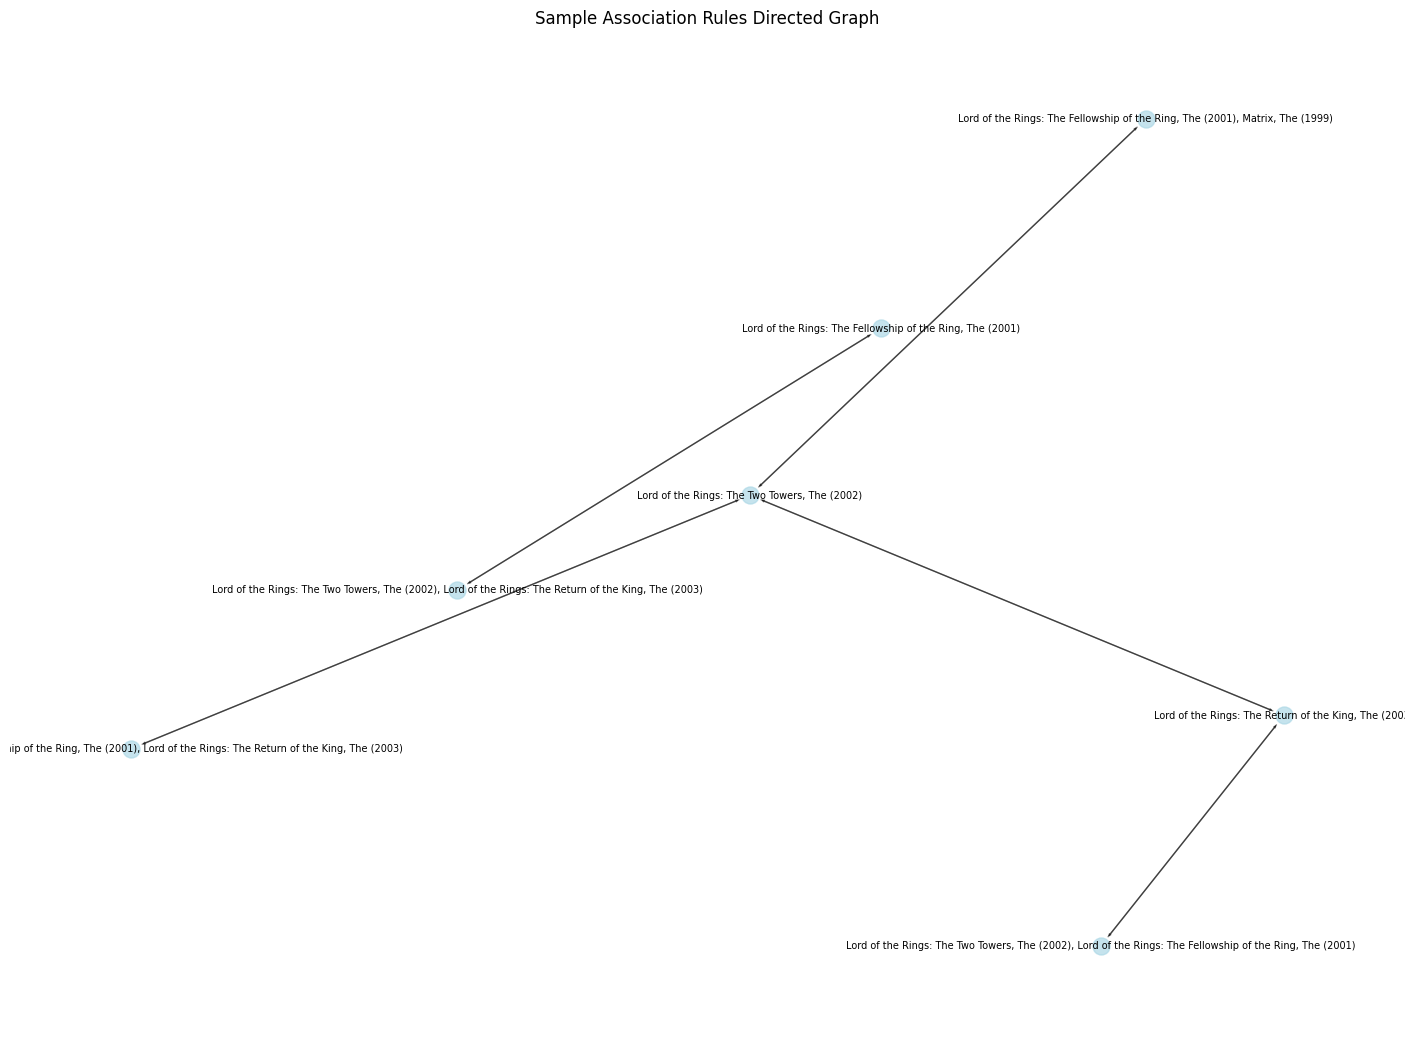

In [342]:
plot_topk_rules_in_graph(rules, frequent_itemsets)

max lift value is 3.7135
max confidence value is 0.9567


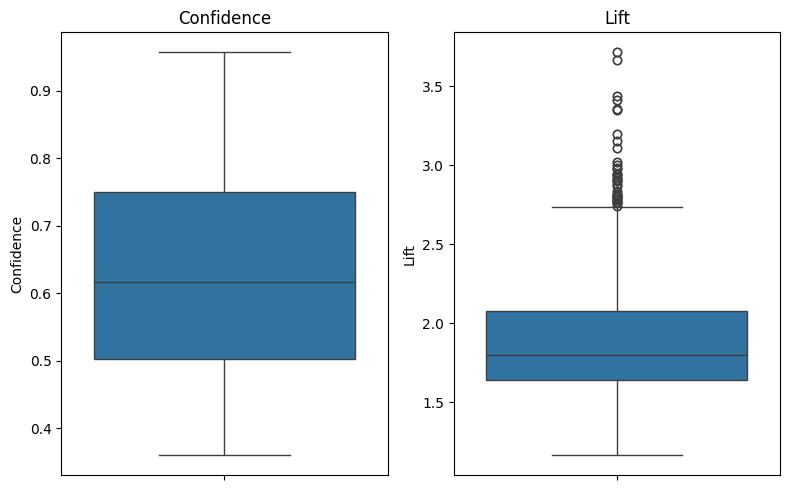

In [343]:
plot_metrics_boxplots(rules)

# Cluster items + Apriori


In [344]:
num_clusters = 50
add_cluster_users_col(num_clusters,transactions)
df = transactions


df = filter_valid_clusters_by_size(df)

/content/TabularDS/final_project/code/utils/clustering.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


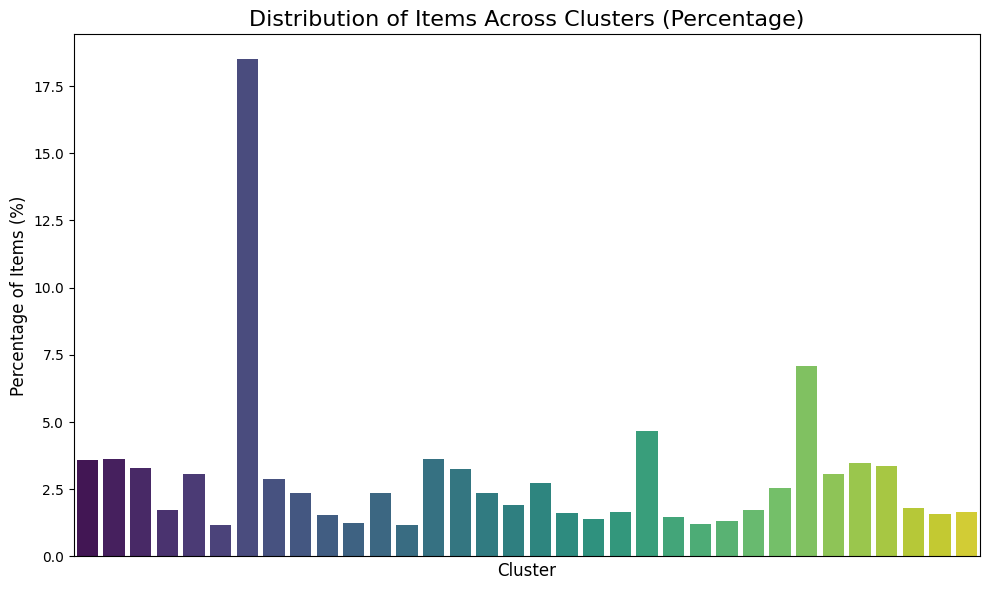

In [345]:
plot_cluster_distribution(df)

In [346]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth


def process_cluster(cluster_id, df, min_support):
    print(f"\nProcessing Cluster {cluster_id}...")

    # Extract transactions of the current cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])

    # Calculate and print sparsity for this cluster
    sparsity = calculate_sparsity(cluster_data)
    print(f"Sparsity of Cluster {cluster_id}: {sparsity:.1f}, size of Cluster is: {len(cluster_data)}")

    # Run FPGrowth
    frequent_itemsets = fpgrowth(cluster_data, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        print(f"No frequent itemsets found in Cluster {cluster_id}.")
        return None

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    print(f"Cluster {cluster_id}: {len(rules)} rules generated.")
    return cluster_id, {"frequent_itemsets": frequent_itemsets, "rules": rules}

def find_clusters_rules(df, min_support):
    cluster_results = {}
    for cluster_id in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])
        # Calculate and filter clusters with less sparsity than desired.
        if df['Cluster'].value_counts()[cluster_id] < 0.025 * len(transactions):
            cluster_results[cluster_id] = cluster_id, {"frequent_itemsets": None, "rules": None}
            continue
        cluster_results[cluster_id] = process_cluster(cluster_id, df, min_support)
    return cluster_results

cluster_results = find_clusters_rules(transactions, min_support=0.5)



Processing Cluster 0...
Sparsity of Cluster 0: 0.9, size of Cluster is: 627
Cluster 0: 0 rules generated.

Processing Cluster 2...
Sparsity of Cluster 2: 0.9, size of Cluster is: 631
Cluster 2: 14 rules generated.

Processing Cluster 4...
Sparsity of Cluster 4: 0.9, size of Cluster is: 577
Cluster 4: 10 rules generated.

Processing Cluster 6...
Sparsity of Cluster 6: 0.9, size of Cluster is: 534
Cluster 6: 8 rules generated.

Processing Cluster 8...
Sparsity of Cluster 8: 1.0, size of Cluster is: 3226
No frequent itemsets found in Cluster 8.

Processing Cluster 9...
Sparsity of Cluster 9: 0.8, size of Cluster is: 504
Cluster 9: 1178 rules generated.

Processing Cluster 15...
Sparsity of Cluster 15: 0.9, size of Cluster is: 630
Cluster 15: 8076 rules generated.

Processing Cluster 16...
Sparsity of Cluster 16: 0.9, size of Cluster is: 566
Cluster 16: 8 rules generated.

Processing Cluster 29...
Sparsity of Cluster 29: 0.9, size of Cluster is: 813
Cluster 29: 12 rules generated.

Proces

In [347]:
import pandas as pd


def aggregate_all_rules(cluster_results, transactions, original_min_support):
    # Initialize an empty list to store all the rules
    all_rules = []

    # Loop through all cluster results and combine the rules
    for id, cluster_data in cluster_results.items():
        if cluster_data is None:
            continue
        rules = cluster_data[1]["rules"]
        if rules is None or rules.empty:
            continue
        rules['Cluster'] = id
        all_rules.append(rules)

    # Concatenate all the rules into a single DataFrame
    all_rules_df = pd.concat(all_rules, ignore_index=True)
    # Remove duplicates if needed
    all_rules_df = all_rules_df.drop_duplicates(subset=['antecedents', 'consequents'])



    # Now calculate the global metrics for all rules in one go
    all_rules_df['global_antecedent_support'] = all_rules_df['antecedents'].apply(
        lambda x: calculate_global_support(set(x), transactions)
    )

    all_rules_df['global_consequent_support'] = all_rules_df['consequents'].apply(
        lambda x: calculate_global_support(set(x), transactions)
    )

    # Calculate global rule support (for antecedent + consequent together)
    all_rules_df['global_rule_support'] = all_rules_df.apply(
        lambda row: calculate_global_support(set(row['antecedents']).union(set(row['consequents'])) , transactions),
        axis=1
    )

    # Calculate global confidence
    all_rules_df['global_confidence'] = all_rules_df['global_rule_support'] / all_rules_df['global_antecedent_support']

    # Calculate global lift
    all_rules_df['global_lift'] = all_rules_df['global_confidence'] / all_rules_df['global_consequent_support']


    comparable_rules = all_rules_df[all_rules_df['global_rule_support'] >= original_min_support]
    print(f"number of rules shared with baseline approach: {len(comparable_rules)}")
    print(f"ratio of shared rules: {len(comparable_rules) / max(len(all_rules_df), 1)}")


    return all_rules_df



In [348]:
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)

number of rules shared with baseline approach: 228
ratio of shared rules: 0.02404556000843704


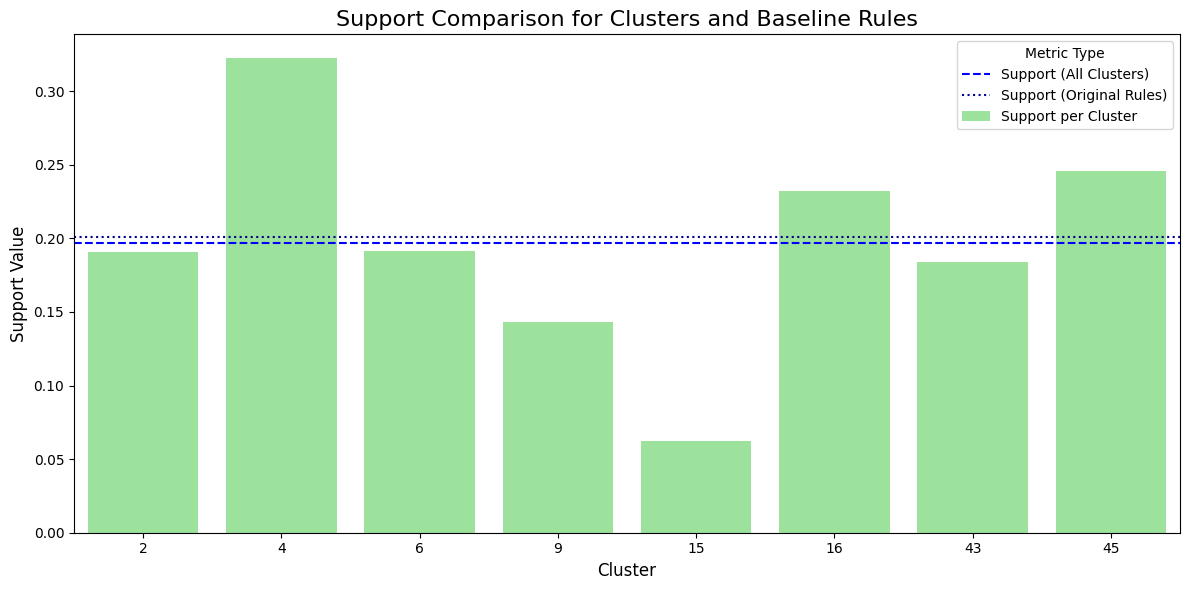

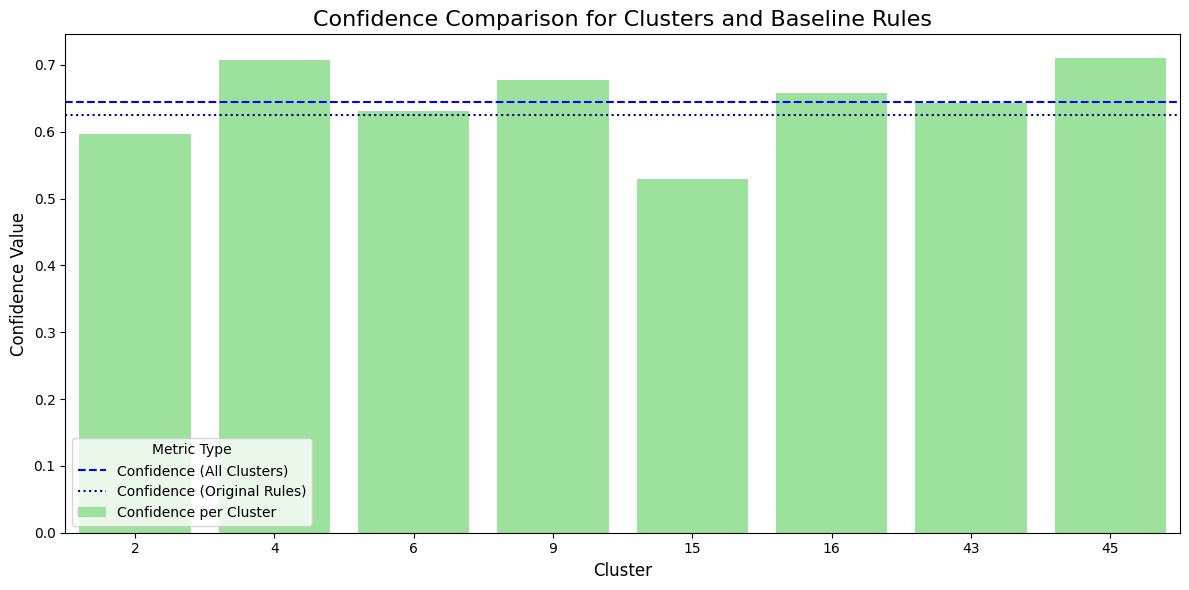

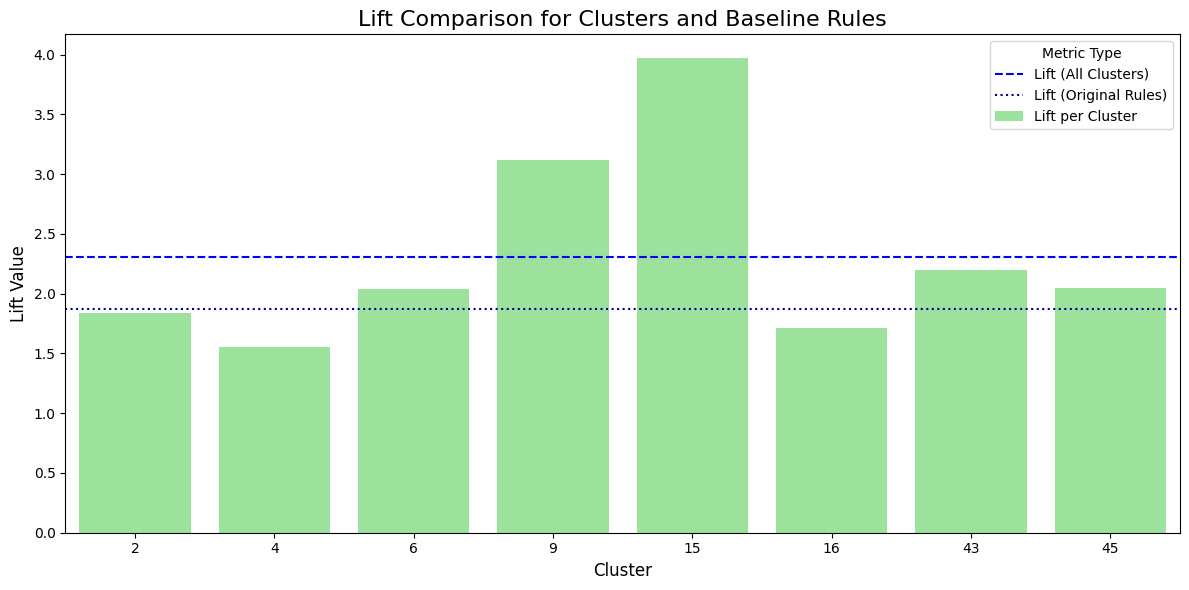

In [349]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_rules_comparison(all_rules_df):
  # Ensure overall_metrics is properly initialized
  overall_metrics = {
      'Support': {},
      'Confidence': {},
      'Lift': {}
  }

  # Group the rules by cluster and calculate the mean for each metric
  cluster_metrics_df = all_rules_df.groupby('Cluster')[['global_rule_support', 'global_confidence', 'global_lift']].mean().reset_index()

  # Compute global averages for all clusters
  if not cluster_metrics_df.empty:
      avg_support_all_clusters = cluster_metrics_df['global_rule_support'].mean()
      avg_confidence_all_clusters = cluster_metrics_df['global_confidence'].mean()
      avg_lift_all_clusters = cluster_metrics_df['global_lift'].mean()
  else:
      avg_support_all_clusters = avg_confidence_all_clusters = avg_lift_all_clusters = 0

  # Add overall metrics for all clusters
  overall_metrics['Support']['All Clusters'] = avg_support_all_clusters
  overall_metrics['Confidence']['All Clusters'] = avg_confidence_all_clusters
  overall_metrics['Lift']['All Clusters'] = avg_lift_all_clusters

  # Compute metrics for original rules
  if original_rules is not None and not original_rules.empty:
      avg_support_original = original_rules["support"].mean()
      avg_confidence_original = original_rules["confidence"].mean()
      avg_lift_original = original_rules["lift"].mean()
  else:
      avg_support_original = avg_confidence_original = avg_lift_original = 0

  # Add original rules metrics to overall metrics
  overall_metrics['Support']['Original Rules'] = avg_support_original
  overall_metrics['Confidence']['Original Rules'] = avg_confidence_original
  overall_metrics['Lift']['Original Rules'] = avg_lift_original

  # Prepare the data for plotting each metric separately
  metrics = ['global_rule_support', 'global_confidence', 'global_lift']
  metric_mapping = {'global_rule_support': 'Support', 'global_confidence': 'Confidence', 'global_lift': 'Lift'}

  # Create individual plots for each metric
  for metric in metrics:
      fig, ax = plt.subplots(figsize=(12, 6))

      # Plot the metrics for each cluster
      sns.barplot(x='Cluster', y=metric, data=cluster_metrics_df, color='lightgreen', label=f'{metric_mapping[metric]} per Cluster', ax=ax)

      # Plot overall metrics (all clusters and original rules)
      ax.axhline(y=overall_metrics[metric_mapping[metric]]['All Clusters'], color='blue', linestyle='--', label=f'{metric_mapping[metric]} (All Clusters)')
      ax.axhline(y=overall_metrics[metric_mapping[metric]]['Original Rules'], color='darkblue', linestyle=':', label=f'{metric_mapping[metric]} (Original Rules)')

      # Add labels and title
      ax.set_title(f'{metric_mapping[metric]} Comparison for Clusters and Baseline Rules', fontsize=16)
      ax.set_xlabel('Cluster', fontsize=12)
      ax.set_ylabel(f'{metric_mapping[metric]} Value', fontsize=12)
      ax.legend(title='Metric Type')

      # Show the plot
      plt.tight_layout()
      plt.show()

plot_rules_comparison(all_rules_df)


# 2. Online Retail Datsaset

In [350]:
transactions = pd.read_csv("/content/TabularDS/final_project/data/online_retail_transactional.csv")
transactions.head()

,10 COLOUR SPACEBOY PEN,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,...,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP ENGLISH ROSE,YOU'RE CONFUSING ME METAL SIGN,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [351]:
import pandas as pd
min_support = 0.05
original_min_support = min_support

## I. Applying Classic Apriori for rule associasion mining


In [352]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

In [353]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 240
                          antecedents                         consequents  \
0          (REGENCY CAKESTAND 3 TIER)  (ROSES REGENCY TEACUP AND SAUCER )   
1  (ROSES REGENCY TEACUP AND SAUCER )          (REGENCY CAKESTAND 3 TIER)   
2   (PACK OF 72 RETROSPOT CAKE CASES)       (60 TEATIME FAIRY CAKE CASES)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.206512            0.099535  0.075581    0.365991  3.677012   
1            0.099535            0.206512  0.075581    0.759346  3.677012   
2            0.148140            0.096744  0.063023    0.425432  4.397491   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.055026    1.420272       0.917518  0.327952   0.295909   
1               1.0  0.055026    3.297214       0.808516  0.327952   0.696714   
2               1.0  0.048692    1.572060       0.906953  0.346547   0.363892   

   kulczynski  
0    0.562668  
1

In [354]:
import numpy as np

print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.0580, Confidence average: 0.5710, Lift average: 5.6758


## II. Cluster items + Apriori


In [355]:
from sklearn.cluster import KMeans

num_clusters = 40
add_cluster_users_col(num_clusters,transactions)
df = transactions

silhouette score of clustering is: 0.08993354884726623


/content/TabularDS/final_project/code/utils/clustering.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


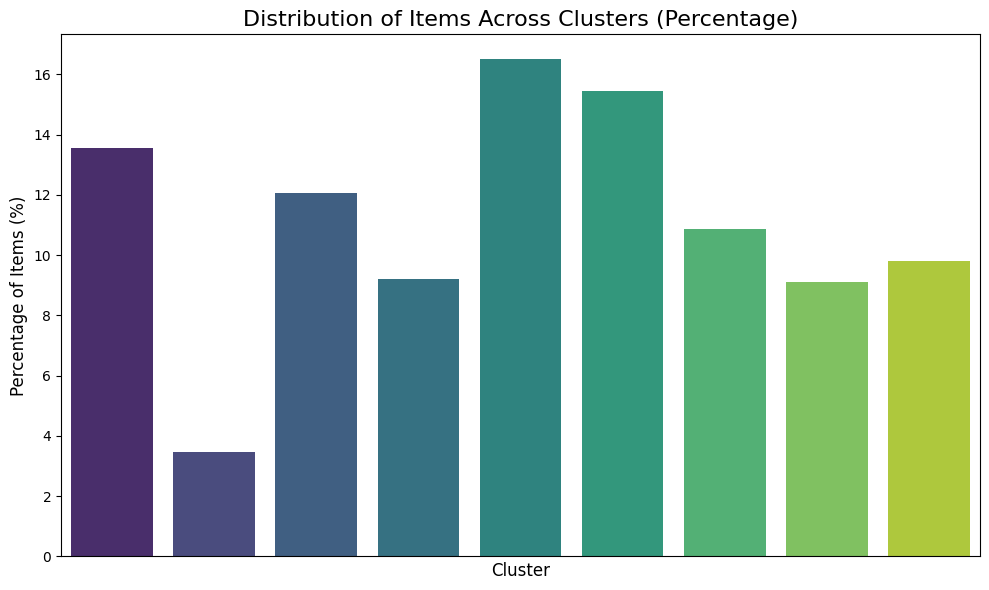

In [360]:
from sklearn.metrics import silhouette_score

score=silhouette_score(df, df['Cluster'])
print(f"silhouette score of clustering is: {score}")



# filter extreme clusters by size. (containing less than 1% or more than 30% of the transactions)
df = filter_valid_clusters_by_size(df)

plot_cluster_distribution(df)


In [357]:
cluster_results = find_clusters_rules(transactions, min_support=0.4)


Processing Cluster 2...
Sparsity of Cluster 2: 0.9, size of Cluster is: 247
Cluster 2: 0 rules generated.

Processing Cluster 7...
Sparsity of Cluster 7: 0.9, size of Cluster is: 220
Cluster 7: 2 rules generated.

Processing Cluster 10...
Sparsity of Cluster 10: 0.9, size of Cluster is: 168
Cluster 10: 24 rules generated.

Processing Cluster 12...
Sparsity of Cluster 12: 0.9, size of Cluster is: 301
Cluster 12: 0 rules generated.

Processing Cluster 13...
Sparsity of Cluster 13: 0.9, size of Cluster is: 282
Cluster 13: 0 rules generated.

Processing Cluster 16...
Sparsity of Cluster 16: 0.9, size of Cluster is: 198
Cluster 16: 0 rules generated.

Processing Cluster 21...
Sparsity of Cluster 21: 0.9, size of Cluster is: 166
Cluster 21: 246 rules generated.

Processing Cluster 28...
Sparsity of Cluster 28: 1.0, size of Cluster is: 2274
No frequent itemsets found in Cluster 28.

Processing Cluster 30...
Sparsity of Cluster 30: 0.9, size of Cluster is: 179
Cluster 30: 1580 rules generated

In [358]:
original_min_support = 0.05
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)


number of rules shared with baseline approach: 140
ratio of shared rules: 0.0755939524838013


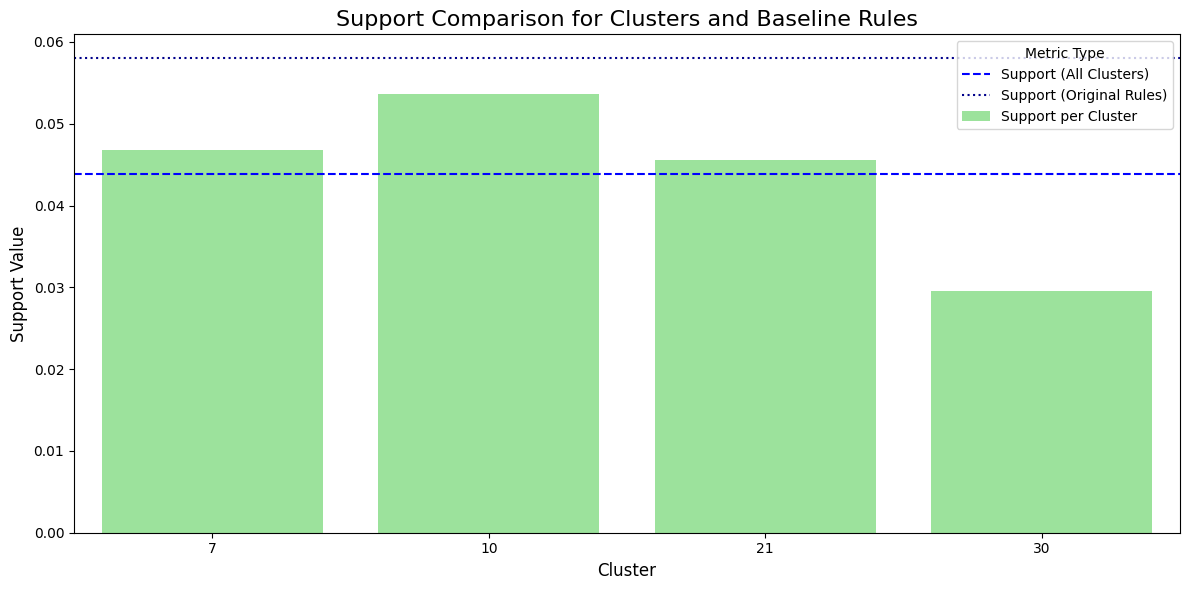

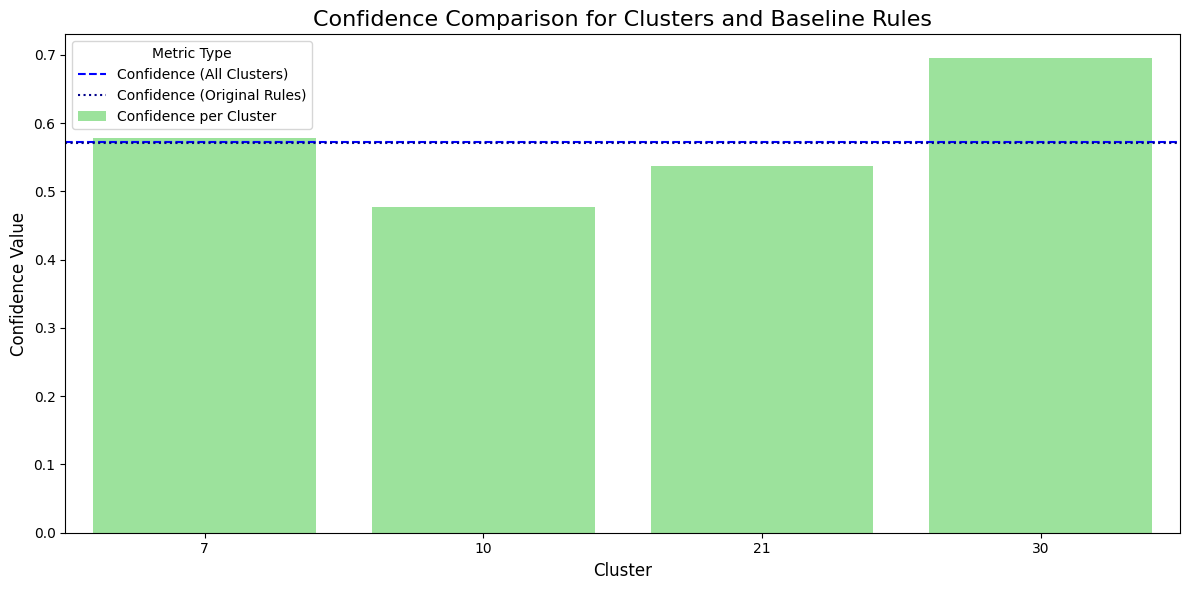

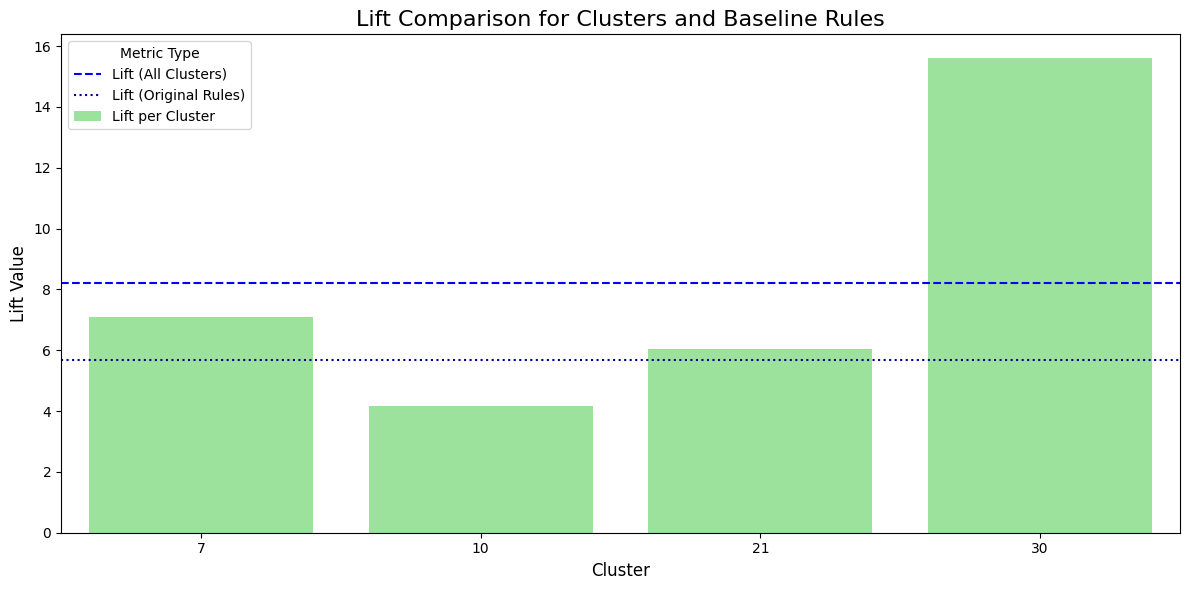

In [359]:
plot_rules_comparison(all_rules_df)